In [1]:
import copy
from typing import Optional, Union

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
from tqdm.notebook import tqdm
import torch
from torch import nn
from torch.utils.data import Dataset
import torchvision

from frouros.callbacks import PermutationTestOnBatchData
from frouros.detectors.data_drift import MMD

# MNIST dataset

A more advanced example is shown below, where MMD {cite:p}`JMLR:v13:gretton12a` is applied as a drift detector to the well-known [MNIST](http://yann.lecun.com/exdb/mnist/) image dataset.

The goal is to apply [GaussianBlur](https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#gaussianblur) and [ElasticTransform](https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#elastictransform) transformations to some of the images in order to simulate a drift process at the feature level (data drift) that would likely end up affecting the performance (concept drift) of a machine learning model.

In order to ensure reproducibility, a set_seed function is use, as well as the device where to perform PyTorch operations (CPU or GPU).

In [2]:
def set_seed(seed=31):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)
    np.random.seed(seed)

In [3]:
set_seed(seed=31)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Data is split in:
- Train: These images will be only used to train an autoencoder that will allow to reduce the dimensionality from 784(28x28x1) to 5 dimensions $\phi : \mathbb{R}^{28x28x1}\rightarrow \mathbb{R}^{5}$, where $\phi$ is the encoder. 30000 samples.

- Reference: These images will represent the samples that come from the training distribution and will act as a reference. 30000 samples.

- Test: These images may belong to the original distribution of the data, or they may suffer some of the transformations mentioned above. 10000 samples.

In [4]:
transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),  # Convert images to the range [0.0, 1.0] (normalize)
    ]
)

batch_size = 64

train_all_dataset = torchvision.datasets.MNIST(
    root="/tmp/mnist/train/",
    train=True,
    download=True,
    transform=transform,
)

test_dataset = torchvision.datasets.MNIST(
    root="/tmp/mnist/test/",
    train=False,
    download=True,
    transform=transform,
)

train_all_dataset_size = len(train_all_dataset)
train_dataset_size = int(train_all_dataset_size * 0.5)
reference_dataset_size = train_all_dataset_size - train_dataset_size

train_dataset, reference_dataset = torch.utils.data.random_split(dataset=train_all_dataset, lengths=[train_dataset_size, reference_dataset_size], generator=torch.Generator().manual_seed(31))

train_data_loader = torch.utils.data.DataLoader(  # 30000 samples
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)

Show some example MNIST images that will be use to train the autoencoder.

In [5]:
def imshow(img):
    npimg = img.numpy()
    fig = plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap=plt.cm.gray)
    fig.tight_layout()
    plt.show()

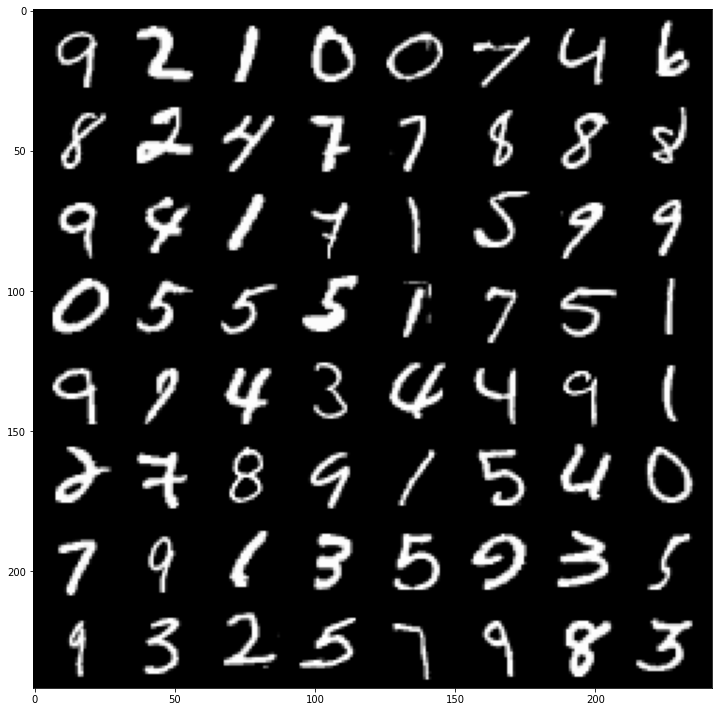

In [6]:
dataiter = iter(train_data_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))

In [7]:
X_train = np.array([X_sample.tolist() for X_sample, _ in tqdm(train_dataset)]).astype(np.float32)
X_ref = np.array([X_sample.tolist() for X_sample, _ in tqdm(reference_dataset)]).astype(np.float32)
X_test = np.array([X_sample.tolist() for X_sample, _ in tqdm(test_dataset)]).astype(np.float32)

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

The following is a definition of the parts that make up the autoencoder.

First, the encoder is implemented, which has a very simple architecture in which a convolution section is used, followed by a flatten layer and finally a normal pair of hidden layers that map the output of the convolution section to the desired dimensional space.

In [8]:
class Encoder(nn.Module):

    def __init__(self, latent_dim: int):
        super().__init__()

        self.encoder_conv = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )

        self.flatten = nn.Flatten(start_dim=1)

        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            nn.Linear(128, latent_dim)
        )

    def forward(self, x):
        x = self.encoder_conv(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x

The decoder simply performs the reverse process of the encoder to obtain the same initial dimensionality reconstructed from the encoder output.

In [9]:
class Decoder(nn.Module):

    def __init__(self, latent_dim: int):
        super().__init__()

        self.decoder_lin = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1,
        unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3,
            stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2,
            padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2,
            padding=1, output_padding=1)
        )

    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

Both blocks combine to form the autoencoder architecture.

In [10]:
class Autoencoder(nn.Module):

    def __init__(self, latent_dim: int) -> None:
        super().__init__()
        self.encoder = Encoder(
            latent_dim=latent_dim,
        )
        self.decoder = Decoder(
            latent_dim=latent_dim,
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

As stated above, the bottleneck dimension of the autoencoder will be 5.

In [11]:
latent_dim = 5

autoencoder = Autoencoder(
    latent_dim=latent_dim,
)

In order to prevent that the autoencoder simple learns to copy the input to the output (identity function), we implement contractive loss {cite:p}`rifai2011contractive` as a regularizer to learn some meaningful representation of the input in the bottleneck dimensions. For the optimizer, Adam {cite:p}`kingma2014adam` is use.

In [12]:
def contractive_loss(outputs_e, outputs, inputs, lamda = 1e-4):
    assert outputs.shape == inputs.shape ,f'outputs.shape : {outputs.shape} != inputs.shape : {inputs.shape}'
    criterion = nn.MSELoss()
    loss1 = criterion(outputs, inputs)

    outputs_e.backward(torch.ones(outputs_e.size()), retain_graph=True)
    loss2 = torch.sqrt(torch.sum(torch.pow(inputs.grad, 2)))
    inputs.grad.data.zero_()

    loss = loss1 + (lamda*loss2)
    return loss

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)

Autoencoder is trained during 3 epochs and printing the loss every 100 batches of images.

In [13]:
epochs = 3

for epoch in range(epochs):

    running_loss = 0.0
    for i, (inputs, _) in enumerate(train_data_loader, 0):
        inputs.requires_grad = True
        inputs.retain_grad()

        outputs_e, outputs = autoencoder(inputs)
        loss = contractive_loss(outputs_e, outputs, inputs)

        inputs.requires_grad = False

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if i % 100 == 99:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')
            running_loss = 0.0

[1,   100] loss: 0.156
[1,   200] loss: 0.086
[1,   300] loss: 0.056
[1,   400] loss: 0.044
[2,   100] loss: 0.036
[2,   200] loss: 0.034
[2,   300] loss: 0.033
[2,   400] loss: 0.032
[3,   100] loss: 0.031
[3,   200] loss: 0.030
[3,   300] loss: 0.030
[3,   400] loss: 0.029


An original training sample is shown below, with the reconstruction made by autoencoder from the 5 dimensions.

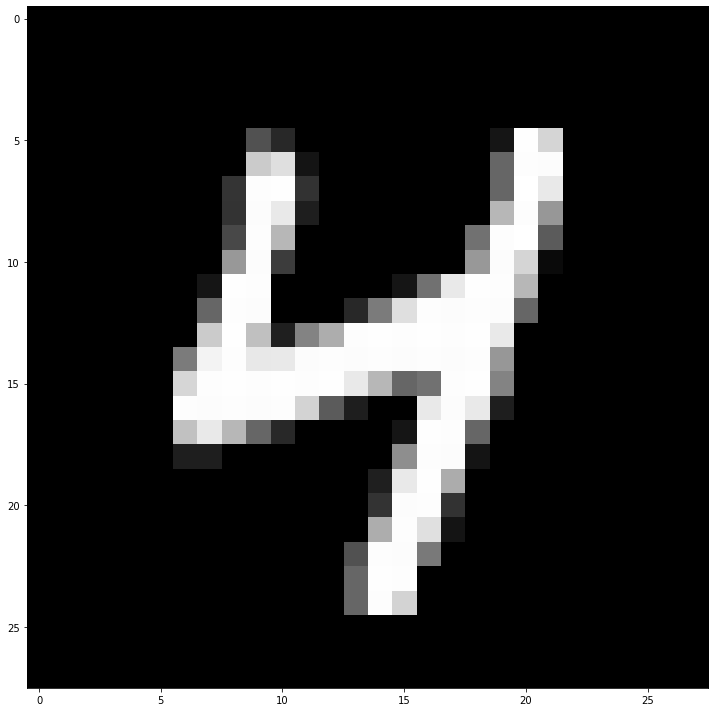

In [14]:
imshow(img=torch.Tensor(X_ref[1]))

In [15]:
test_sample = torch.Tensor(np.expand_dims(X_ref[1], axis=0))
_, X_reconstructed = autoencoder(test_sample)
X_reconstructed = torch.squeeze(X_reconstructed, axis=0)

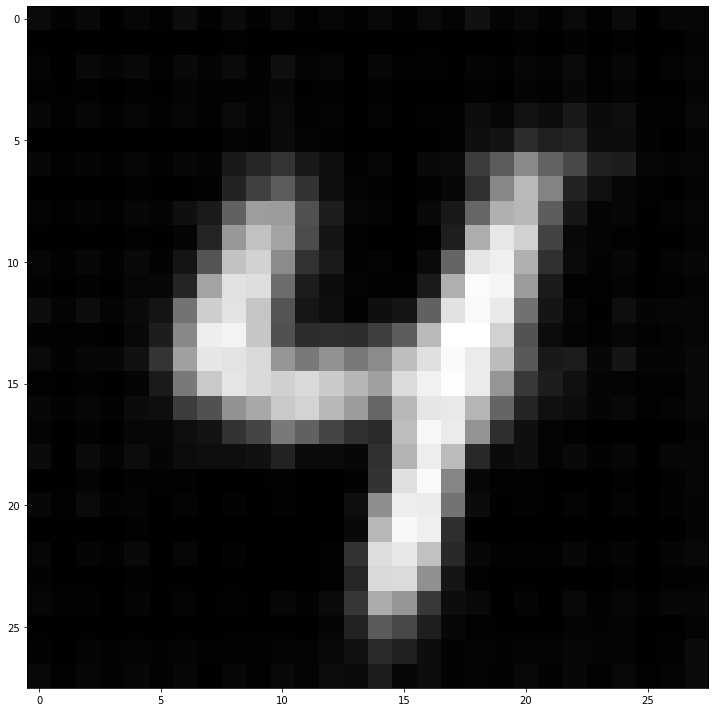

In [16]:
imshow(img=X_reconstructed.detach())

In [17]:
test_dataset = torchvision.datasets.MNIST(
    root="/tmp/mnist/test-2/",
    train=False,
    download=True,
)

A custom dataset class is used to apply each transformation to the images.

In [18]:
class CustomMNIST(Dataset):

    def __init__(
        self,
        subset,
        transform: Optional[Union[torch.nn.Module, torchvision.transforms.Compose]] = None
    ) -> None:
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self) -> int:
        return len(self.subset)

In [19]:
gaussian_blur_dataset = CustomMNIST(
    subset=test_dataset,
    transform=torchvision.transforms.Compose(
        [
            torchvision.transforms.GaussianBlur(
                kernel_size=(5, 9),
                sigma=(0.1, 2.5)),
            torchvision.transforms.ToTensor(),
        ],
    ),
)

elastic_transform_dataset = CustomMNIST(
    subset=test_dataset,
    transform=torchvision.transforms.Compose(
        [
            torchvision.transforms.ElasticTransform(alpha=75.0, sigma=5.0),
            torchvision.transforms.ToTensor(),
        ],
    ),
)

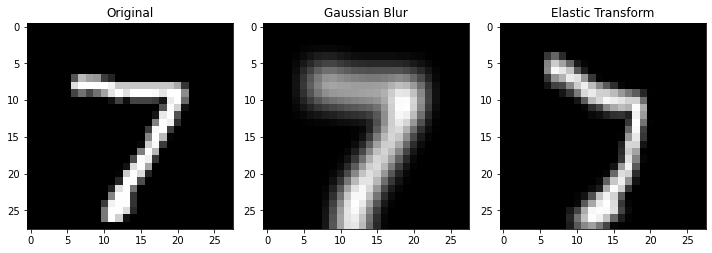

In [20]:
fig, axs = plt.subplots(nrows=1,
                        ncols=3,
                        figsize=(10, 10))

for ax, img, title in zip(axs.flat,
                          [torchvision.transforms.ToTensor()(test_dataset[0][0]),
                           gaussian_blur_dataset[0][0],
                           elastic_transform_dataset[0][0]],
                          ["Original",
                           "Gaussian Blur",
                           "Elastic Transform"]):
    ax.imshow(np.transpose(img, (1, 2, 0)), cmap=plt.cm.gray)
    ax.set_title(title)

fig.tight_layout()
plt.show()

The encoder part of the trained autoencoder is used to obtain the 5 latent dimensions of the reference dataset.

In [21]:
X_test_gaussian_blur = np.array([X_sample.tolist() for X_sample, _ in tqdm(gaussian_blur_dataset)]).astype(np.float32)
X_test_elastic_transform = np.array([X_sample.tolist() for X_sample, _ in tqdm(elastic_transform_dataset)]).astype(np.float32)

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [22]:
with torch.no_grad():
    X_ref_encoded = autoencoder.encoder(torch.Tensor(X_ref)).numpy()
    X_test_gaussian_blur_encoded = autoencoder.encoder(torch.Tensor(X_test_gaussian_blur)).numpy()
    X_test_elastic_transform_encoded = autoencoder.encoder(torch.Tensor(X_test_elastic_transform)).numpy()

A significance level of $\alpha = 0.05$ is set to perform the hypothesis test.

In [23]:
alpha = 0.05

Maximum Mean Discrepancy (MMD) {cite:p}`JMLR:v13:gretton12a` imported from Frouros is used with a Radial Basis Function kernel (RBF), set by default in MMD. In addition to calculating the corresponding MMD statistic, p-value is estimated using permutation test.

**Note:**
Only 1000 of the 30000 samples of the reference dataset are used to fit the detector, as well as 1000 samples per each of the three test datasets (reference, gaussian blur and elastic transform). This is due to the high memory requirements demanded by MMD.

In [24]:
num_samples = 1000

detector = MMD(
    callbacks=[
        PermutationTestOnBatchData(
            num_permutations=1000,
            random_state=31,
            num_jobs=-1,
            name="permutation_test",
            verbose=False,
        ),
    ],
)
_ = detector.fit(X=X_ref_encoded[:num_samples])

In [25]:
X_ref_sample = X_ref_encoded[np.random.randint(low=num_samples, high=X_ref_encoded.shape[0], size=num_samples)]
X_gaussian_blur_sample = X_test_gaussian_blur_encoded[np.random.randint(low=0, high=X_test_gaussian_blur_encoded.shape[0], size=num_samples)]
X_elastic_transform_sample = X_test_elastic_transform_encoded[np.random.randint(low=0, high=X_test_elastic_transform_encoded.shape[0], size=num_samples)]

Compare each test dataset to the dataset fitted by MMD.

In [ ]:
permutation_test_logs = {}

for sample, type_ in zip([X_ref_sample,
                          X_gaussian_blur_sample,
                          X_elastic_transform_sample],
                         ["Reference",
                          "GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 2.5))",
                          "ElasticTransform(alpha=75.0, sigma=5.0)"]
                         ):
    mmd, callbacks_logs = detector.compare(X=sample)
    permutation_test_logs[type_] = copy.copy(callbacks_logs["permutation_test"])
    mmd, p_value = mmd.distance, callbacks_logs["permutation_test"]["p_value"]
    print(f"{type_}:\n  MMD statistic={round(mmd, 4)}, p-value={round(p_value, 4)}, drift={p_value < alpha}")

Reference:
  MMD statistic=0.0023, p-value=0.166, drift=False
GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 2.5)):
  MMD statistic=0.0046, p-value=0.0, drift=True


As expected, GaussianBlur and ElasticTransform datasets are significantly different (drift) from the reference dataset. Test reference samples are confirmed to be from the sample distribution of the original dataset (no drift).

The following are the graphs of the permutation tests.

In [ ]:
num_bins = 25
x_values = 100
num_percentile = 100-alpha*100

fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(5, 8), sharex=True, sharey=True, dpi=600)

for ax, (type_, permutation_test) in zip(axs.flat, permutation_test_logs.items()):

    permutation_tests = permutation_test["permuted_statistics"]
    observed_statistic = permutation_test["observed_statistic"]
    p_value = permutation_test["p_value"]

    ax.hist(permutation_tests, bins=num_bins, density=True)
    xs = np.linspace(min(permutation_tests), max(permutation_tests), num=x_values)
    permutation_tests_density = gaussian_kde(permutation_tests).evaluate(xs)
    ax.plot(xs, permutation_tests_density, label="KDE")
    ax.axvline(observed_statistic, color="green", linestyle="--", label="Observed distance")
    percentile = np.percentile(permutation_tests, q=num_percentile)
    ax.axvline(percentile, color="red", linestyle="--", label="Target distance")
    ax.text(percentile, 250, s=f"p-value = {p_value}", rotation=270, color="red", fontsize=10)
    ax.set_title(type_)
    ax.legend(fontsize=8)
    drift = p_value < alpha
    ax.text(0.8, 0.15, "Drift" if drift else "No drift", transform=ax.transAxes, fontsize=12, bbox={"boxstyle": "round", "facecolor": "red" if drift else "green", "alpha":0.5})

fig.suptitle("Permutation tests", fontsize="x-large")
fig.supxlabel("Distance")
fig.supylabel("Density")
fig.tight_layout()
plt.show()

```{bibliography}
:filter: docname in docnames
```